# Infer ***peroxisome*** - part 5️⃣

--------------
## **OBJECTIVE**
### <input type="checkbox"/> Infer sub-cellular component  ***peroxisomes***  
Segment the ***peroxisomes*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged SKL, a membrane targeting sequence.

---------------------
## infer ***peroxisomes***
### summary of steps 

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the peroxisomes marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - ‘Dot’ thresholding method (AICSSeg)

  - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

**POST-PROCESSING**
- **`STEP 4`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 5`** - Label objects

    - label unique peroxisome objects based on connectivity

**EXPORT** ➡️
- save labeled ***peroxisomes*** (perox, PR) as unsigned integer 16-bit tif files



> ###### **Generally following the Allen Cell Segmenter procedure for segmentation of perixisomes from the [playground_dots.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_dots.ipynb) notebook**

---------------------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook. 

In [1]:
from pathlib import Path
import os

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)

from infer_subc.core.img import *                                     

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [2]:
# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = ".tiff"

## Define the path to the directory that contains the input image folder.
data_root_path = Path(os.getcwd()).parents[1] / "sample_data" /  "example_neuron"

## Specify which subfolder that contains the input data
in_data_path = data_root_path / "raw"

## Specify the output folder
out_data_path = data_root_path / "seg"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

#### &#x1F3C3; **Run code; no user input required**

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - perox***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the peroxisomes marker (channel number = user input)

In [5]:
###################
# INPUT
###################
PEROX_CH = 5
raw_perox = select_channel_from_raw(img_data, PEROX_CH)

# ***PRE-PROCESSING prototype - perox***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [6]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 0

struct_img =  scale_and_smooth(raw_perox,
                               median_size = median_sz,
                               gauss_sigma = gauss_sig)

# ***CORE-PROCESSING prototype - perox***

## **`STEP 3` -  ‘Dot’ thresholding method (AICSSeg)**

- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

In [7]:
###################
# CORE_PROCESSING
###################
# segment small round structures with this
dot_scale_1 = 0.01
dot_cut_1 = 0.15

dot_scale_2 = 1
dot_cut_2 = 0.1

dot_scale_3 = 0
dot_cut_3 = 0

dot_method = "3D"

bw_extra = dot_filter_3(struct_img,
                        dot_scale_1,
                        dot_cut_1,
                        dot_scale_2,
                        dot_cut_2,
                        dot_scale_3,
                        dot_cut_3,
                        dot_method)

# ***POST-PROCESSING prototype - perox***

## **`STEP 4` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [8]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 2

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_extra, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - perox***

## **`STEP 5` - Label objects**

- label unique peroxisome objects based on connectivity

In [9]:
###################
# LABELING
###################
peroxisomes_labels = label_uint16(cleaned_img2)

In [10]:
peroxisomes_labels.dtype

dtype('uint16')

## **Visualize with `napari` 1**
Visualize the first-pass segmentation and labeling with `napari`.

In [11]:
viewer = napari.Viewer(title = "perox",
                       ndisplay=3)

In [12]:
viewer.add_image(
    struct_img,
    scale = scale,
    name = "Peroxisome Intensities")

viewer.add_image(
    cleaned_img2,
    scale = scale,
    opacity= 0.3,
    name = "Peroxisome Segmentation")

viewer.add_image(
    peroxisomes_labels,
    scale = scale,
    opacity=0.3,
    name = "Peroxisome Labels")

<Image layer 'Peroxisome Labels' at 0x1870de096c0>

# ***EXTRACTION prototype - perox***

- save labeled ***peroxisomes*** (perox, PR) as unsigned integer 16-bit tif files

In [13]:
out_file_n = export_inferred_organelle(peroxisomes_labels, "perox", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-perox


In [14]:
# Whether or not to include the segmentation in the batch processing performed in part 2 of infer-subc (quantification)
to_batch = True
if to_batch:
    out_file_b = export_inferred_organelle(peroxisomes_labels,
                                           "perox",
                                           meta_dict,
                                           Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-perox


# **Define `_infer_perox` function**

> ###### 📝 **these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use**

In [15]:
##########################
#  infer_perox
##########################
def _infer_perox( 
        in_img: np.ndarray,
        peroxi_ch: int,
        median_sz: int,
        gauss_sig: float,
        dot_scale_1: float,
        dot_cut_1: float,
        dot_scale_2: float,
        dot_cut_2: float,
        dot_scale_3: float,
        dot_cut_3: float,
        dot_method: str,
        hole_min_width: int,
        hole_max_width: int,
        small_object_width: int,
        fill_filter_method: str
        ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
 
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    peroxi = select_channel_from_raw(in_img, peroxi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    peroxi =  scale_and_smooth(peroxi,
                               median_size = median_sz,
                               gauss_sigma = gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    bw = dot_filter_3(peroxi, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=hole_min_width, 
                                             hole_max=hole_max_width, 
                                             min_size=small_object_width,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


# **Test  `_infer_perox` function**

In [16]:
_perox_object =  _infer_perox(
        img_data,
        PEROX_CH,
        median_sz,
        gauss_sig,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2, 
        dot_scale_3,
        dot_cut_3,
        dot_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method) 

_perox_object.dtype

dtype('uint16')

In [17]:
np.all(peroxisomes_labels == _perox_object)

True

## **Visualize with `napari` 2**

In [18]:
viewer.add_image(
    _perox_object,
    scale = scale,
    opacity=0.3,
    name = "Peroxisome Object",
    colormap='hsv')

<Image layer 'Peroxisome Object' at 0x18701b97100>

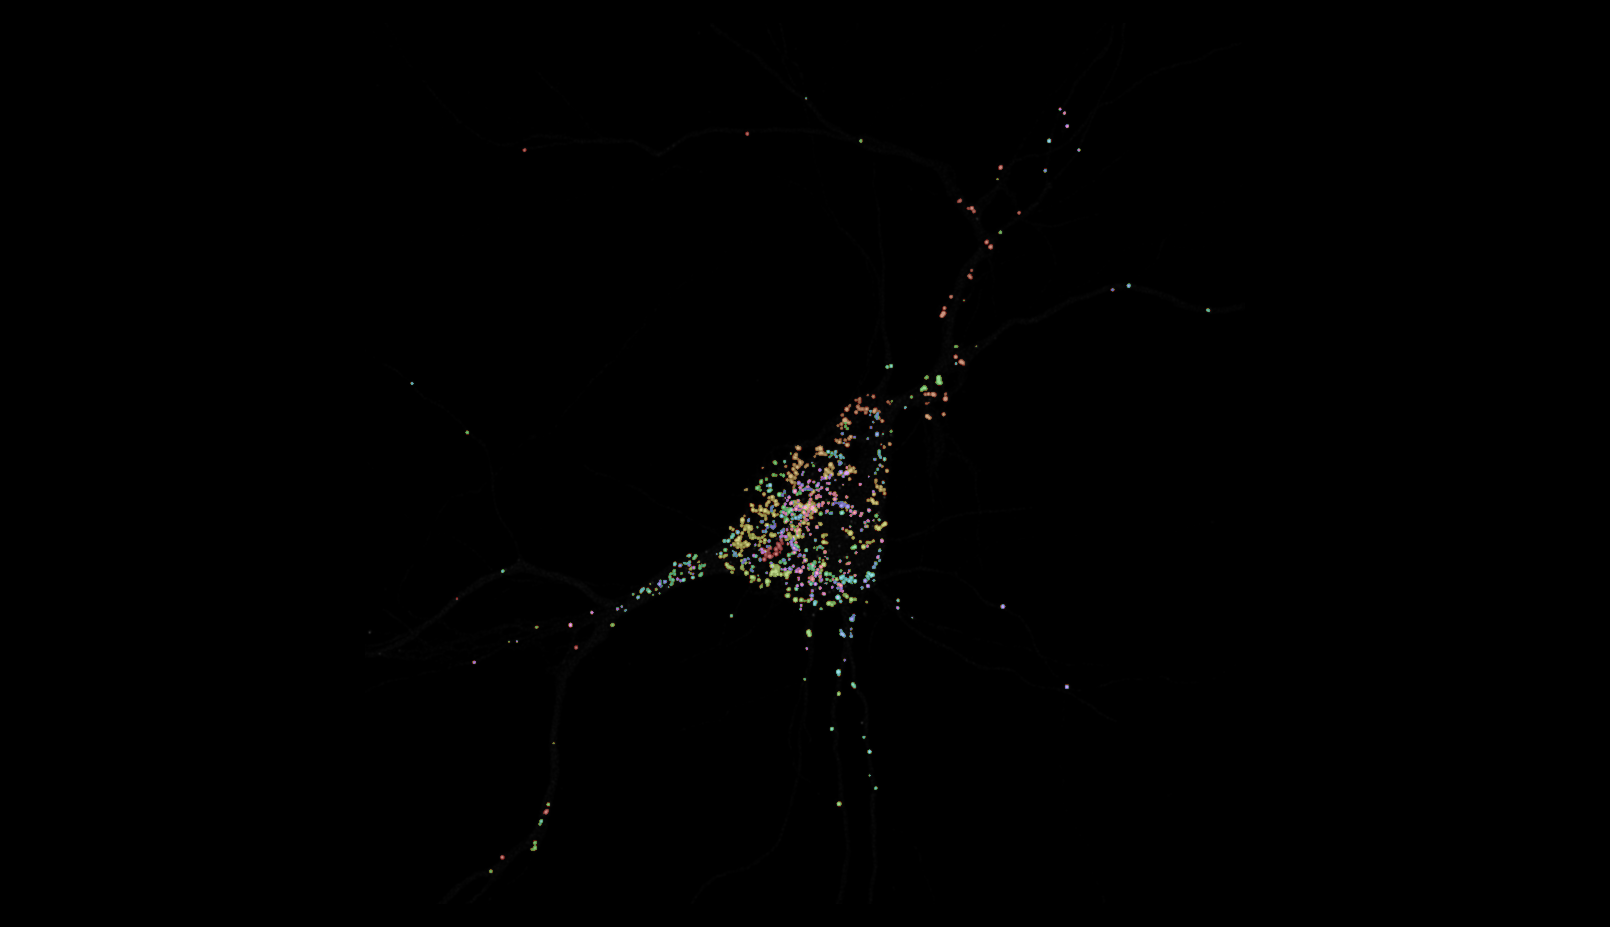

In [19]:
nbscreenshot(viewer, canvas_only=True)

In [20]:
viewer.close()

-------------
### NEXT: INFER ENDOPLASMIC RETICULUM

proceed to [1.6_infer_ER.ipynb](./1.6_infer_ER.ipynb)
